In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
data_dir = "../input/"
files_train = [f"train_image_data_{fid}.parquet" for fid in range(4)]

F = os.path.join(data_dir, files_train[0])

df_train = pd.read_parquet(F)
df_train.head()


,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


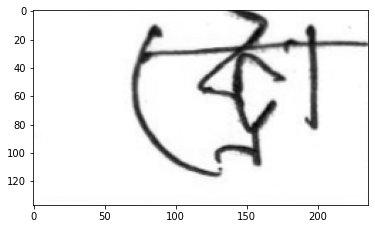

In [3]:
idx = 0
img = df_train.iloc[idx, 1:].values.astype(np.uint8)

plt.imshow(img.reshape(137, 236), cmap="gray")  # HEIGHT, WIDTH 순서
plt.show()


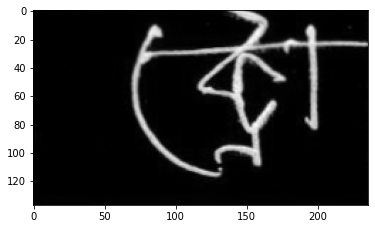

In [4]:
idx = 0
img = df_train.iloc[idx, 1:].values.astype(np.uint8)
img = 255 - img  # 이미지 색 반전

plt.imshow(img.reshape(137, 236), cmap="gray")  # HEIGHT, WIDTH 순서
plt.show()

In [5]:
df_train

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,Train_50205,247,250,250,250,252,250,250,250,251,...,246,248,252,252,249,248,250,247,243,243
50206,Train_50206,250,251,250,244,245,243,246,248,246,...,255,255,255,255,255,255,255,255,255,253
50207,Train_50207,246,245,246,246,245,245,247,247,245,...,247,246,248,246,245,248,249,246,243,245
50208,Train_50208,246,242,240,244,247,242,239,241,245,...,247,247,247,247,247,246,246,248,248,247


<AxesSubplot: >

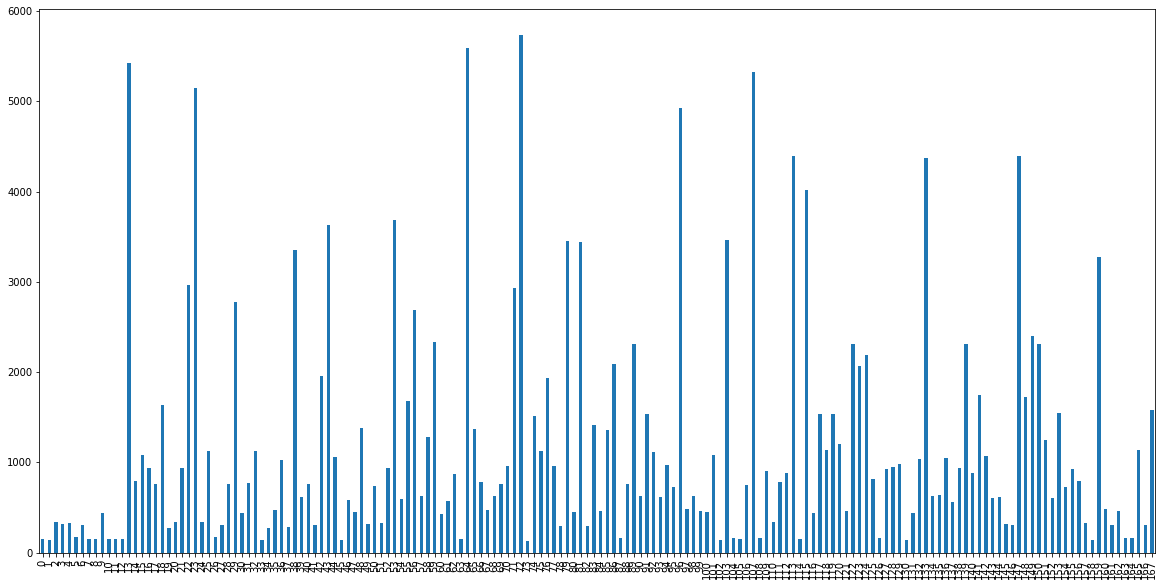

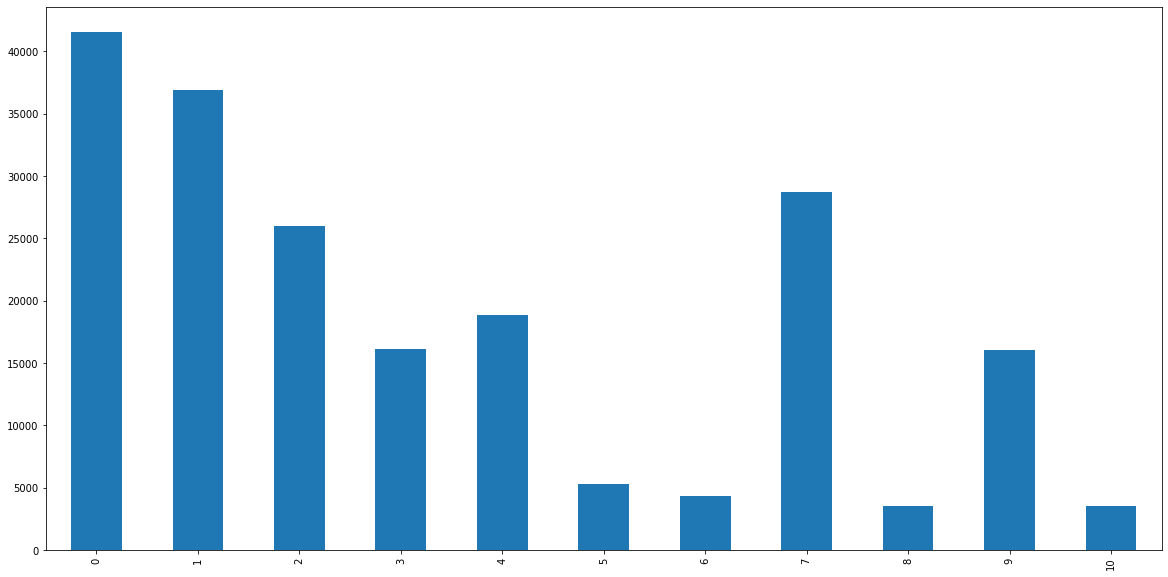

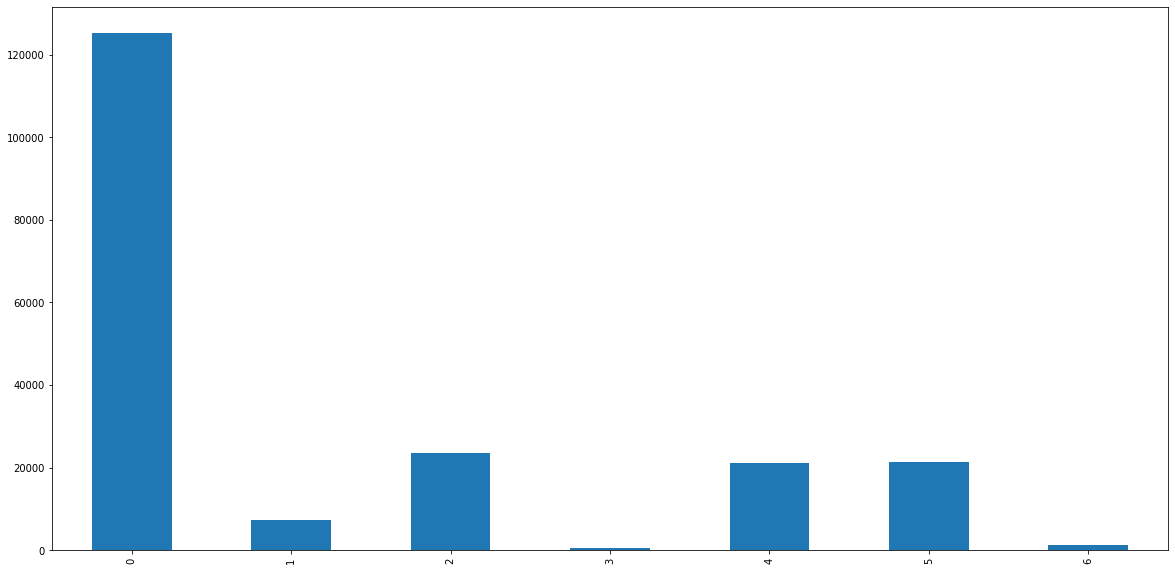

In [6]:
df_train = pd.read_csv('../input/train.csv')

plt.figure(figsize=(20, 10))
df_train["grapheme_root"].value_counts().sort_index().plot.bar()

plt.figure(figsize=(20, 10))
df_train["vowel_diacritic"].value_counts().sort_index().plot.bar()

plt.figure(figsize=(20, 10))
df_train["consonant_diacritic"].value_counts().sort_index().plot.bar()


In [7]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

X = df_train[["image_id", "grapheme_root", "vowel_diacritic", "consonant_diacritic"]].values[
    :, 0
]
y = df_train[["image_id", "grapheme_root", "vowel_diacritic", "consonant_diacritic"]].values[
    :, 1:
]

mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)
df_train["fold"] = -1
for i, (trn_idx, vld_idx) in enumerate(mskf.split(X, y)):
    df_train.loc[vld_idx, "fold"] = i
df_train["fold"] = df_train["fold"].astype(int)

df_train.to_csv("../input/df_folds.csv", index=False)

In [8]:
import joblib
from tqdm import tqdm

In [9]:
for fname in files_train:
    F = os.path.join(data_dir, fname)
    df_train = pd.read_parquet(F)
    img_ids = df_train["image_id"].values
    img_array = df_train.iloc[:, 1:].values
    for idx in tqdm(range(len(df_train))):
        img_id = img_ids[idx]
        img = img_array[idx]
        joblib.dump(img, f"../input/train_images/{img_id}.pkl")

100%|██████████| 50210/50210 [02:44<00:00, 304.93it/s]


In [10]:
df_train = pd.read_csv("../input/train.csv")
df_train["fold"] = pd.read_csv("../input/df_folds.csv")["fold"]

trn_fold = [i for i in range(5) if i not in [4]]
vld_fold = [4]
trn_idx = df_train.loc[df_train["fold"].isin(trn_fold)].index
vld_idx = df_train.loc[df_train["fold"].isin(vld_fold)].index

trn_df = df_train.loc[trn_idx]
vld_df = df_train.loc[vld_idx] 

In [11]:
csv = trn_df.reset_index()
img_ids = csv["image_id"].values
img_height = 137
img_width = 236

index = 0
img_id = img_ids[index]
img = joblib.load(f"../input/train_images/{img_id}.pkl")
img = img.reshape(img_height, img_width).astype(np.uint8)
img = 255 - img
img = img[:, :, np.newaxis]
img = np.repeat(img, 3, 2)


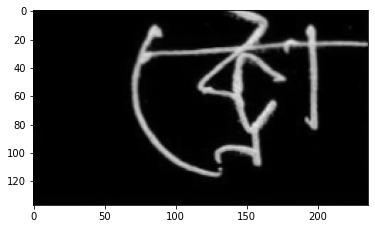

In [12]:
plt.imshow(img)
plt.show()

In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
image_size = 224
train_transform = A.Compose(
    [
        A.RandomResizedCrop(height=image_size, width=image_size),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0.05, p=0.5),
        A.RGBShift(r_shift_limit=0.05, g_shift_limit=0.05, b_shift_limit=0.05, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

valid_transfrom = A.Compose(
    [
        A.Resize(height=image_size, width=image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


- pip install imgaug
- pip install iterative-stratification
- pip install -U albumentations[imgaug]
- apt-get update
- apt-get -y install libgl1-mesa-glx

In [14]:
label_1 = csv.iloc[index].grapheme_root
label_2 = csv.iloc[index].vowel_diacritic
label_3 = csv.iloc[index].consonant_diacritic

In [15]:
from torch.utils.data import Dataset

class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_ids = csv["image_id"].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f"../input/train_images/{img_id}.pkl")
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img

        img = img[:, :, np.newaxis]
        img = np.repeat(img, 3, 2)
        if self.transform is not None:
            img = self.transform(image=img)["image"]

        label_1 = self.csv.iloc[index].grapheme_root
        label_2 = self.csv.iloc[index].vowel_diacritic
        label_3 = self.csv.iloc[index].consonant_diacritic

        return img, np.array([label_1, label_2, label_3]) 


In [16]:
trn_dataset = BengaliDataset(
    csv=trn_df, img_height=137, img_width=236, transform=train_transform
)

vld_dataset = BengaliDataset(
    csv=vld_df, img_height=137, img_width=236, transform=valid_transfrom
)


In [17]:
from torch.utils.data import DataLoader

trn_loader = DataLoader(trn_dataset, shuffle=True, num_workers=4, batch_size=128)
vld_loader = DataLoader(vld_dataset, shuffle=False, num_workers=4, batch_size=128)

In [18]:
import torch
import torch.nn as nn
import pretrainedmodels

model_name = "resnet34"
model = pretrainedmodels.__dict__[model_name](pretrained="imagenet")
in_features = model.last_linear.in_features
model.last_linear = torch.nn.Linear(in_features, 186)

model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", verbose=True, patience=7, factor=0.5
)


In [19]:
from sklearn.metrics import recall_score
best_score = 0.0

for e in range(1): # increate epoch
    train_loss = []
    model.train()

    for inputs, targets in tqdm(trn_loader):
        inputs = inputs.cuda()  # GPU 에서의 학습을 위해 cuda tensor 로 변환합니다.
        targets = targets.cuda()

        logits = model(inputs)
        # grapheme, vowel, cons 개수가 맞게, logits 을 나눠줍니다.
        grapheme = logits[:, :168]
        vowel = logits[:, 168:179]
        cons = logits[:, 179:]

        loss = (
            loss_fn(grapheme, targets[:, 0])
            + loss_fn(vowel, targets[:, 1])
            + loss_fn(cons, targets[:, 2])
        )

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())

    val_loss = []
    val_true = []
    val_pred = []

    model.eval()

    with torch.no_grad():  # evalution 을 위해 gradient 계산을 하지 않습니다.
        for inputs, targets in tqdm(vld_loader):
            inputs = inputs.cuda()
            targets = targets.cuda()

            logits = model(inputs)

            grapheme = logits[:, :168]
            vowel = logits[:, 168:179]
            cons = logits[:, 179:]

            loss = (
                loss_fn(grapheme, targets[:, 0])
                + loss_fn(vowel, targets[:, 1])
                + loss_fn(cons, targets[:, 2])
            )

            val_loss.append(loss.item())

            grapheme = grapheme.cpu().argmax(dim=1).data.numpy()
            vowel = vowel.cpu().argmax(dim=1).data.numpy()
            cons = cons.cpu().argmax(dim=1).data.numpy()

            val_true.append(targets.cpu().numpy())
            val_pred.append(np.stack([grapheme, vowel, cons], axis=1))

    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)

    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)

    score_g = recall_score(val_true[:, 0], val_pred[:, 0], average="macro")
    score_v = recall_score(val_true[:, 1], val_pred[:, 1], average="macro")
    score_c = recall_score(val_true[:, 2], val_pred[:, 2], average="macro")

    final_score = np.average([score_g, score_v, score_c], weights=[2, 1, 1])

    print(
        f"train_loss: {train_loss:.5f}; "
        f"val_loss: {val_loss:.5f}; "
        f"score: {final_score:.5f}"
    )
    print(
        f"score_g: {score_g:.5f}; "
        f"score_v: {score_v: .5f}; "
        f"score_c: {score_c: .5f}"
    )

    if final_score > best_score:
        best_score = final_score

        state_dict = model.cpu().state_dict()
        model = model.cuda()
        torch.save(state_dict, "model.pt")


100%|██████████| 314/314 [00:33<00:00,  9.36it/s]


train_loss: 3.90834; val_loss: 1.46866; score: 0.76023
score_g: 0.65619; score_v:  0.92656; score_c:  0.80197
